In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q -U watermark
!pip install -qq transformers
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.9.0+cu102
transformers: 4.8.1



In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import json
import html

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
dir = '/content/drive/My Drive/Other Programming Files/botternaught'
df = pd.read_csv(f'{dir}/redditors.csv')

In [ ]:
df.head()

,comment_karma,comments,created_utc,has_verified_email,is_bot,is_default_icon,is_gold,is_mod,post_karma,submissions,username
0,-7,"[{""body"":""By submitting to an independent, non...",1.467681e+09,True,True,True,False,False,1,"[{""created_utc"":1472950699,""num_comments"":0,""s...",BlackToLive
1,-5,"[{""body"":""Only 125? Why not 10?\nIslamic state...",1.431683e+09,False,True,True,False,False,1,"[{""created_utc"":1434699494,""num_comments"":0,""s...",FaurnFlamebreaker
2,-4,"[{""body"":""This is one of the best seal documen...",1.445054e+09,False,True,True,False,False,1,"[{""created_utc"":1445054371,""num_comments"":5,""s...",bill_jonson
3,0,[],1.431694e+09,False,True,True,False,False,1,"[{""created_utc"":1442389020,""num_comments"":0,""s...",PurebringerOghmagra
4,-2,"[{""body"":""Haha! That's exactly what me BFF and...",1.442424e+09,False,True,True,False,False,1,"[{""created_utc"":1443861740,""num_comments"":1,""s...",clawisma


In [ ]:
df.comments[0]

json_data = json.loads(df.comments[0])
print(json_data)

[{'body': 'By submitting to an independent, non-profit community, the authors volunteered on a Good Samaritan basis to spread wokeness', 'controversiality': 1, 'created_utc': 1467741509, 'gilded': 0, 'nest_level': 4, 'reply_delay': 1097, 'score': 0, 'subreddit': 'politics'}, {'body': "Sorry, but if you bothered to read the article below the video you could've gotten the point", 'controversiality': 0, 'created_utc': 1467740879, 'gilded': 0, 'nest_level': 2, 'reply_delay': 819, 'score': 0, 'subreddit': 'politics'}, {'body': 'That is not a personal blog', 'controversiality': 0, 'created_utc': 1467740272, 'gilded': 0, 'nest_level': 2, 'reply_delay': 144, 'score': -1, 'subreddit': 'politics'}]


In [ ]:
def combine_comments(comments):
  txt = ''
  json_data = json.loads(comments)
  results = []
  for comment in json_data:
    results += [html.unescape(comment['body'])]
  return results

df['comments'] = df['comments'].apply(combine_comments)

In [ ]:
def combine_submissions(submissions):
  txt = ''
  json_data = json.loads(submissions)
  results = []
  for submission in json_data:
    results += [html.unescape(submission['title'])]
  return results

df['submissions'] = df['submissions'].apply(combine_submissions)

In [ ]:
print("~~~~Comment Examples~~~~")
print(df.comments[0])
print(df.comments[8769])

print()
print("~~~~Submission Example~~~~")
print(df.submissions[10084])

~~~~Comment Examples~~~~
['By submitting to an independent, non-profit community, the authors volunteered on a Good Samaritan basis to spread wokeness', "Sorry, but if you bothered to read the article below the video you could've gotten the point", 'That is not a personal blog']
['I dont care if I see an advertisement.  It is me who has the right to rock the vote.  But i should decide not other people what is useful and what is nonuseful to me.', "Hopefully not. There's no reason to vote down things simply because of where or who they come from, votes should be based on the quality of what's there.\r\n\r\nPoingnant! and well said!!!"]

~~~~Submission Example~~~~
['My boss is on Reddit...']


In [ ]:
df[df['has_verified_email'].isnull()]

,comment_karma,comments,created_utc,has_verified_email,is_bot,is_default_icon,is_gold,is_mod,post_karma,submissions,username
896,60,"[Not smoking, prefer alcohol. , I hope it won'...",1.441762e+09,NaN,True,True,False,False,2646,"[""My cat upon realising she was no longer livi...",ironzion17
900,1,"[Either hard or no at all. , That's why they b...",1.444880e+09,NaN,True,True,False,False,3391,"[Cats do not like fruit, He's been here about ...",kanyebreeze
917,1,[There are some but heavily oppressed as I've ...,1.444879e+09,NaN,True,True,False,False,5237,"[After fighting all afternoon, my dogs fell as...",reggaebull
919,0,[],1.441762e+09,NaN,True,True,False,False,5485,"[""Savannah cat. It’s a cat that looks like a l...",deusexmachina112
963,370,[I hope you didn’t serve that to anyone you re...,1.354425e+09,NaN,False,True,False,False,2474,"[PS3 chill sessions, How much money did you be...",relaxandtaketokes
...,...,...,...,...,...,...,...,...,...,...,...
9175,1,"[Okay, so I'm brand new to gray market trading...",1.423255e+09,NaN,False,True,False,False,1,[],dvisic
9217,16,[I feel like this should be on a dota2circleje...,1.430431e+09,NaN,False,True,False,False,1,"[Amateur Tournaments, Headset Recommendations?...",huyster_sc
9255,0,[His impressions are very impressive. ],1.453329e+09,NaN,False,True,False,False,1,"[Top 11 Vegan Restaurants in Salt Lake City, U...",vegantiandra
9452,6,[[( ͡° ͜ʖ ͡°) *Your Comment Has Been Euphorifi...,1.398792e+09,NaN,False,True,False,False,2,[me irl],Euphorify


In [ ]:
# df = df[df['EPS'].notna()]
df = df.dropna().reset_index(drop=True)

In [ ]:
# df
# print(len(df.index))
df

,comment_karma,comments,created_utc,has_verified_email,is_bot,is_default_icon,is_gold,is_mod,post_karma,submissions,username
0,-7,"[By submitting to an independent, non-profit c...",1.467681e+09,True,True,True,False,False,1,[Cops really be trying hard to take non-black ...,BlackToLive
1,-5,[Only 125? Why not 10?\nIslamic state has capt...,1.431683e+09,False,True,True,False,False,1,[This maine coon of mine is way too shy],FaurnFlamebreaker
2,-4,[This is one of the best seal documentaries i'...,1.445054e+09,False,True,True,False,False,1,[Terrifying Secrets of US Navy SEALs Special F...,bill_jonson
3,0,[],1.431694e+09,False,True,True,False,False,1,"[Can you relate to this?, My mom always said y...",PurebringerOghmagra
4,-2,[Haha! That's exactly what me BFF and me will ...,1.442424e+09,False,True,True,False,False,1,[BUT - Kids say the darnedest things about the...,clawisma
...,...,...,...,...,...,...,...,...,...,...,...
10009,6,"[I see some downsides to slowly ""convert"" peop...",1.385611e+09,False,False,True,False,False,1,[],someappels
10010,0,"[Good, because I always ignore them. I hope th...",1.496510e+09,False,False,True,False,False,2,[Religious based spiritual harassment],jesusisfake2
10011,2,"[Thanks for the input, its appreciated, I beli...",1.428655e+09,False,False,True,False,False,1,"[My mother (50 hates my wife (28), My wife hat...",H4ppychappy
10012,2363,[You sure can! Give me just a moment and I'll ...,1.373857e+09,True,False,True,False,True,91,"[[FST] Star Wand, Nook Miles, Many Fossils, DI...",themosthandsomeface


In [ ]:
df["has_verified_email"] = df["has_verified_email"].astype(int)
df["is_bot"] = df["is_bot"].astype(int)
df["is_default_icon"] = df["is_default_icon"].astype(int)
df["is_gold"] = df["is_gold"].astype(int)
df["is_mod"] = df["is_mod"].astype(int)

df = df.drop(["created_utc"], axis = 1)
df = df.drop(["username"], axis = 1)

In [ ]:
df.head()

,comment_karma,comments,has_verified_email,is_bot,is_default_icon,is_gold,is_mod,post_karma,submissions
0,-7,"[By submitting to an independent, non-profit c...",1,1,1,0,0,1,[Cops really be trying hard to take non-black ...
1,-5,[Only 125? Why not 10?\nIslamic state has capt...,0,1,1,0,0,1,[This maine coon of mine is way too shy]
2,-4,[This is one of the best seal documentaries i'...,0,1,1,0,0,1,[Terrifying Secrets of US Navy SEALs Special F...
3,0,[],0,1,1,0,0,1,"[Can you relate to this?, My mom always said y..."
4,-2,[Haha! That's exactly what me BFF and me will ...,0,1,1,0,0,1,[BUT - Kids say the darnedest things about the...


In [ ]:
print(df[df['is_bot'] == True])
print(df[df['is_bot'] == False])

     comment_karma  ...                                        submissions
0               -7  ...  [Cops really be trying hard to take non-black ...
1               -5  ...           [This maine coon of mine is way too shy]
2               -4  ...  [Terrifying Secrets of US Navy SEALs Special F...
3                0  ...  [Can you relate to this?, My mom always said y...
4               -2  ...  [BUT - Kids say the darnedest things about the...
..             ...  ...                                                ...
929          32373  ...  [Guy Kawasaki talks about tokens, How does Tie...
930             24  ...  [This is what our leader's got to do!, Next da...
931            146  ...  [Meet 80-Year-Old South African Designer Respo...
932           3275  ...  [Homeland Security to Compile Database of Jour...
933              0  ...  [The Man who upvotes everything, When you dead...

[934 rows x 9 columns]
       comment_karma  ...                                        submissions

In [ ]:
print(df.shape)
print(df.info())

(10014, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10014 entries, 0 to 10013
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comment_karma       10014 non-null  int64 
 1   comments            10014 non-null  object
 2   has_verified_email  10014 non-null  int64 
 3   is_bot              10014 non-null  int64 
 4   is_default_icon     10014 non-null  int64 
 5   is_gold             10014 non-null  int64 
 6   is_mod              10014 non-null  int64 
 7   post_karma          10014 non-null  int64 
 8   submissions         10014 non-null  object
dtypes: int64(7), object(2)
memory usage: 704.2+ KB
None


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


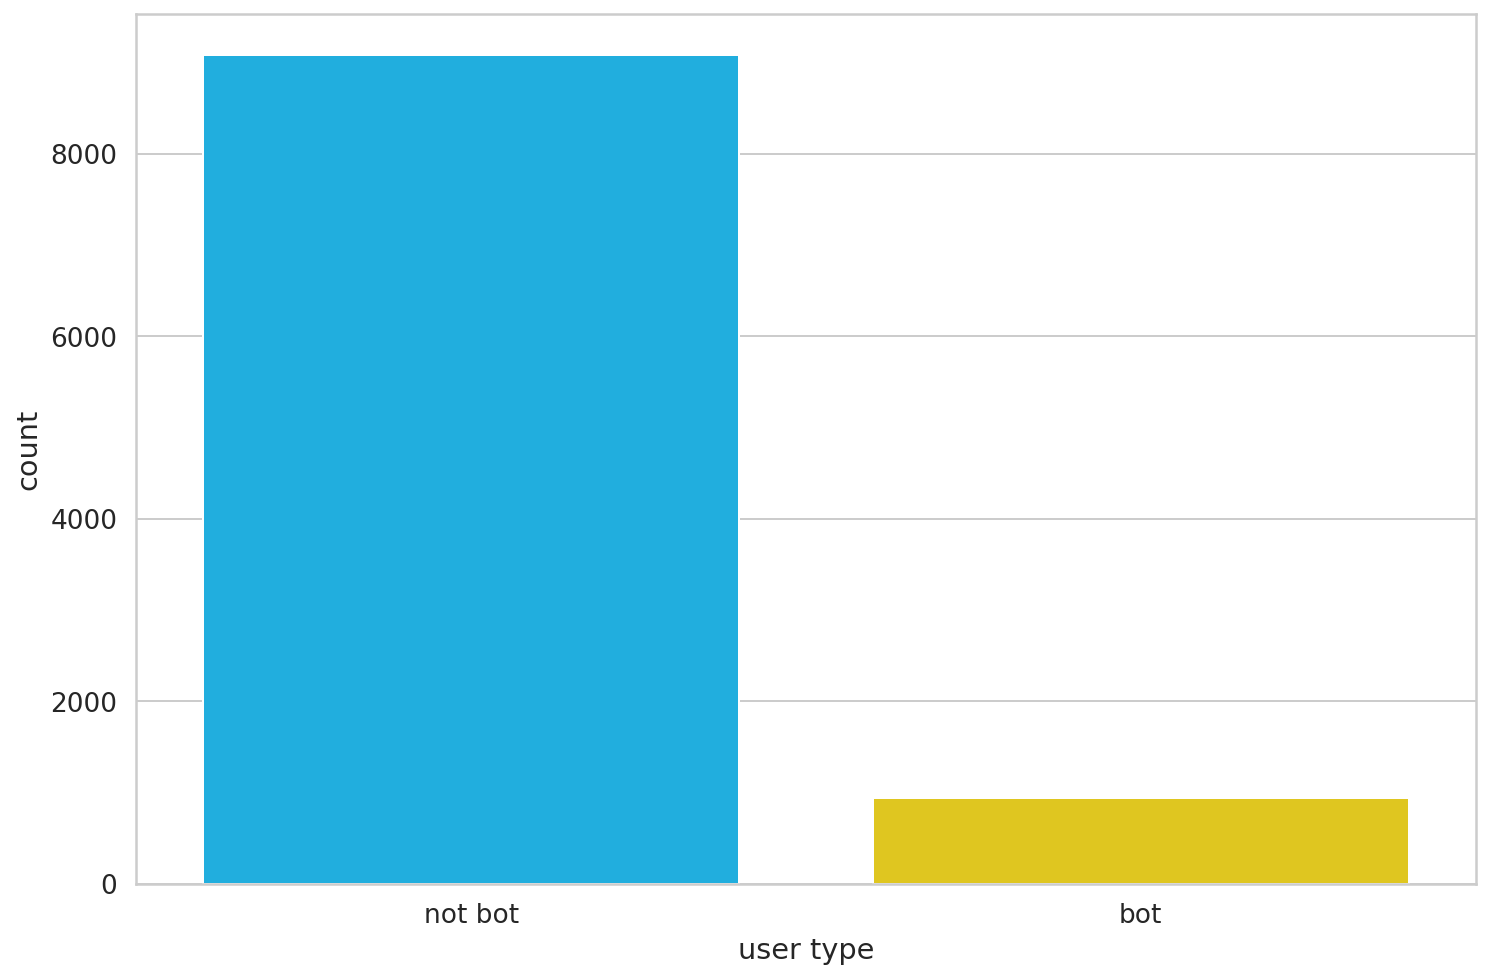

In [ ]:
class_names = ['not bot', 'bot']
ax = sns.countplot(df.is_bot)
plt.xlabel('user type');
ax.set_xticklabels(class_names);

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: {'input_ids': [101, 1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Token IDs: [100, 100, 100]


In [ ]:
sample_txt = df.comments[8769]
tokens = tokenizer.tokenize(sample_txt[0])
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: ["Holding on to the back of the prostitute's head", 'Have you gone back to Mexico?', 'According to a comment in this thread there have been some people on the cock while on the clock.', 'Physical air conditioning units. The sword-sharp edge of the one in my dorm has fucked my thigh in the ass so many times.', "My grandmother once told me that when she lived in the country as a child, her parents would make her and her siblings put their cat's kittens into a sack and throw them into the river. They were rather poor then and she said she never understood exactly what they were doing until she moved to the city. ", '[This one made me shrink into my seat a little.](https://yt3.ggpht.com/-Z151q4ECyeA/AAAAAAAAAAI/AAAAAAAAAAA/9JyKTQRwQ9M/s900-c-k-no/photo.jpg)', 'Students *actually going to class*.', 'That if I can\'t "get over someone" or "something" then I didn\'t have to try and force myself to make that happen immediately *just because* someone else told me that I should. I rea

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt[0],
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
a = encoding['input_ids']
b = torch.zeros((1,32), dtype=torch.long)
print(encoding['input_ids'])
print(encoding['attention_mask'])
print(torch.zeros(1,32))
print(a.shape, b.shape)
print(torch.cat((a,b)))

tensor([[  101, 14382,  1113,  1106,  1103,  1171,  1104,  1103, 21803,   112,
           188,  1246,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([1, 32]) torch.Size([1, 32])
tensor([[  101, 14382,  1113,  1106,  1103,  1171,  1104,  1103, 21803,   112,
           188,  1246,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,

In [ ]:
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

32
tensor([  101, 14382,  1113,  1106,  1103,  1171,  1104,  1103, 21803,   112,
          188,  1246,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])


['[CLS]',
 'Holding',
 'on',
 'to',
 'the',
 'back',
 'of',
 'the',
 'prostitute',
 "'",
 's',
 'head',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
comment_token_lens = []
num_comments = []

for comment in df.comments:
  num_comments.append(len(comment))
  for txt in comment:
    tokens = tokenizer.encode(txt, max_length=512)
    comment_token_lens.append(len(tokens))

[2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


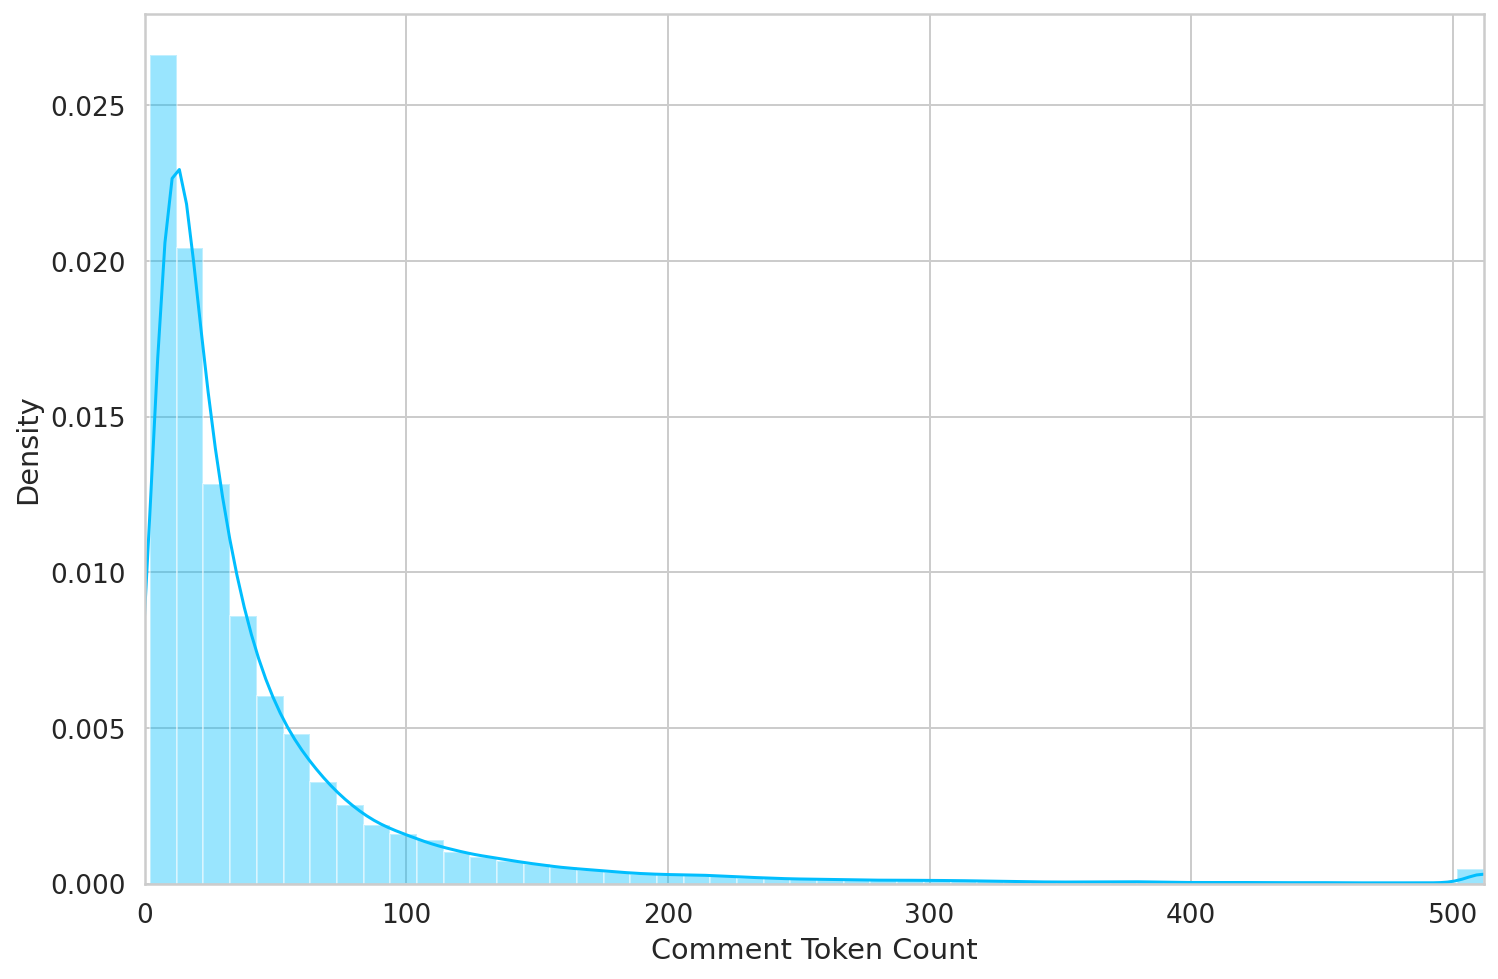

In [ ]:
comment_token_lens.sort()
print(comment_token_lens)
sns.distplot(comment_token_lens)
plt.xlim([0, 512]);
plt.xlabel('Comment Token Count');

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


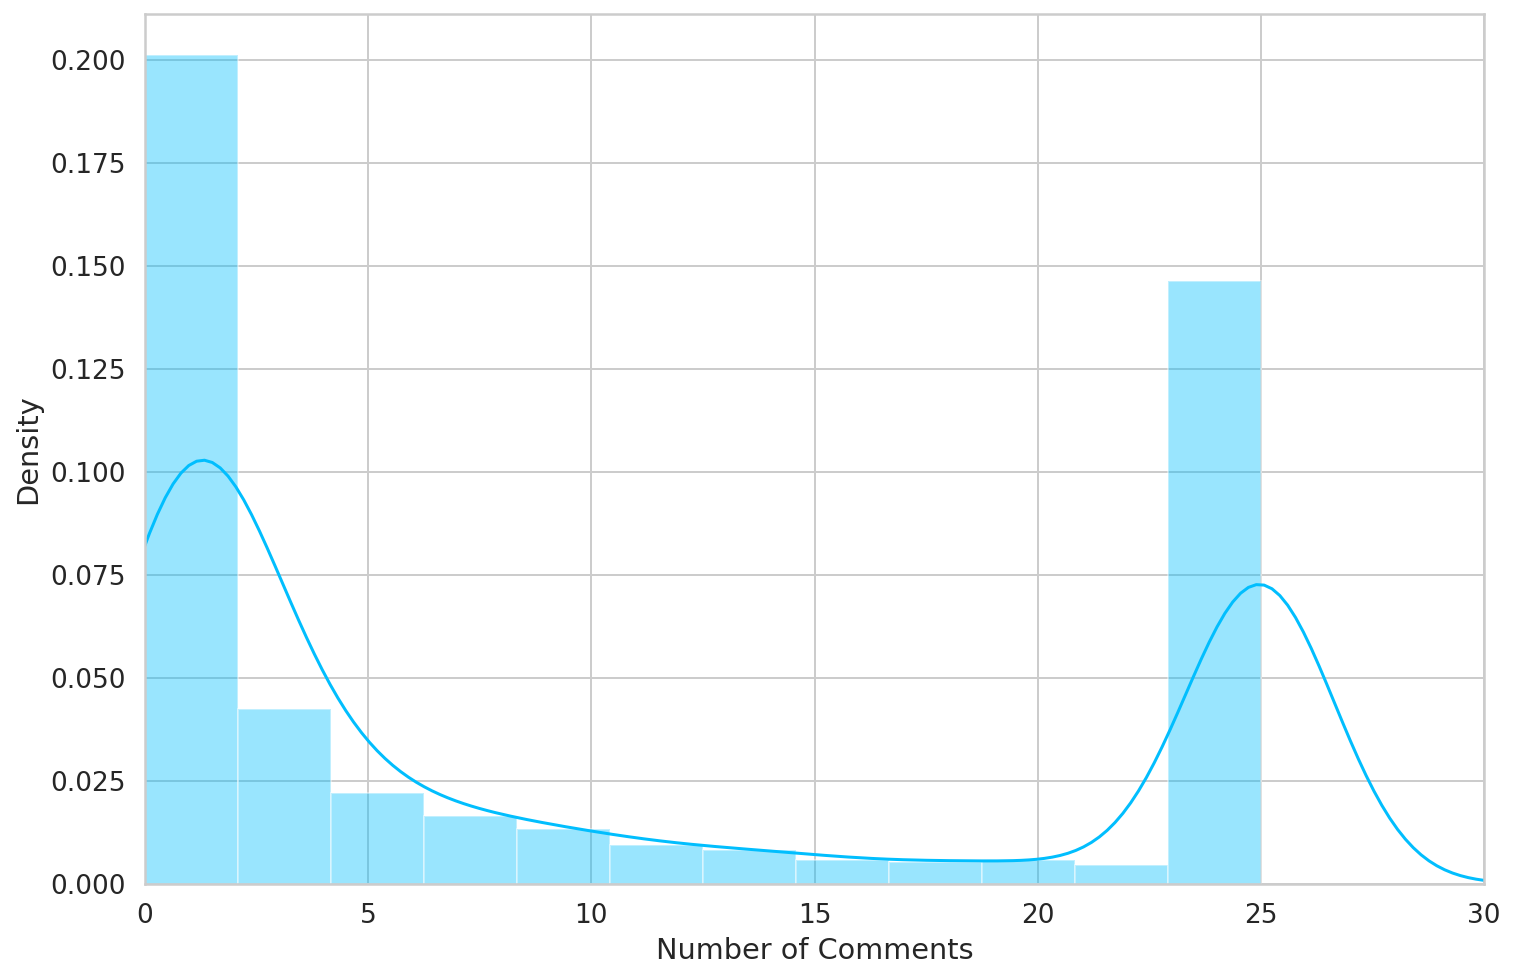

In [ ]:
num_comments.sort()
print(num_comments)
print(max(num_comments))
sns.distplot(num_comments)
plt.xlim([0, 30]);
plt.xlabel('Number of Comments');

In [ ]:
submission_token_lens = []
num_submissions = []

for submission in df.submissions:
  num_submissions.append(len(submission))
  for txt in submission:
    tokens = tokenizer.encode(txt, max_length=512)
    submission_token_lens.append(len(tokens))

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


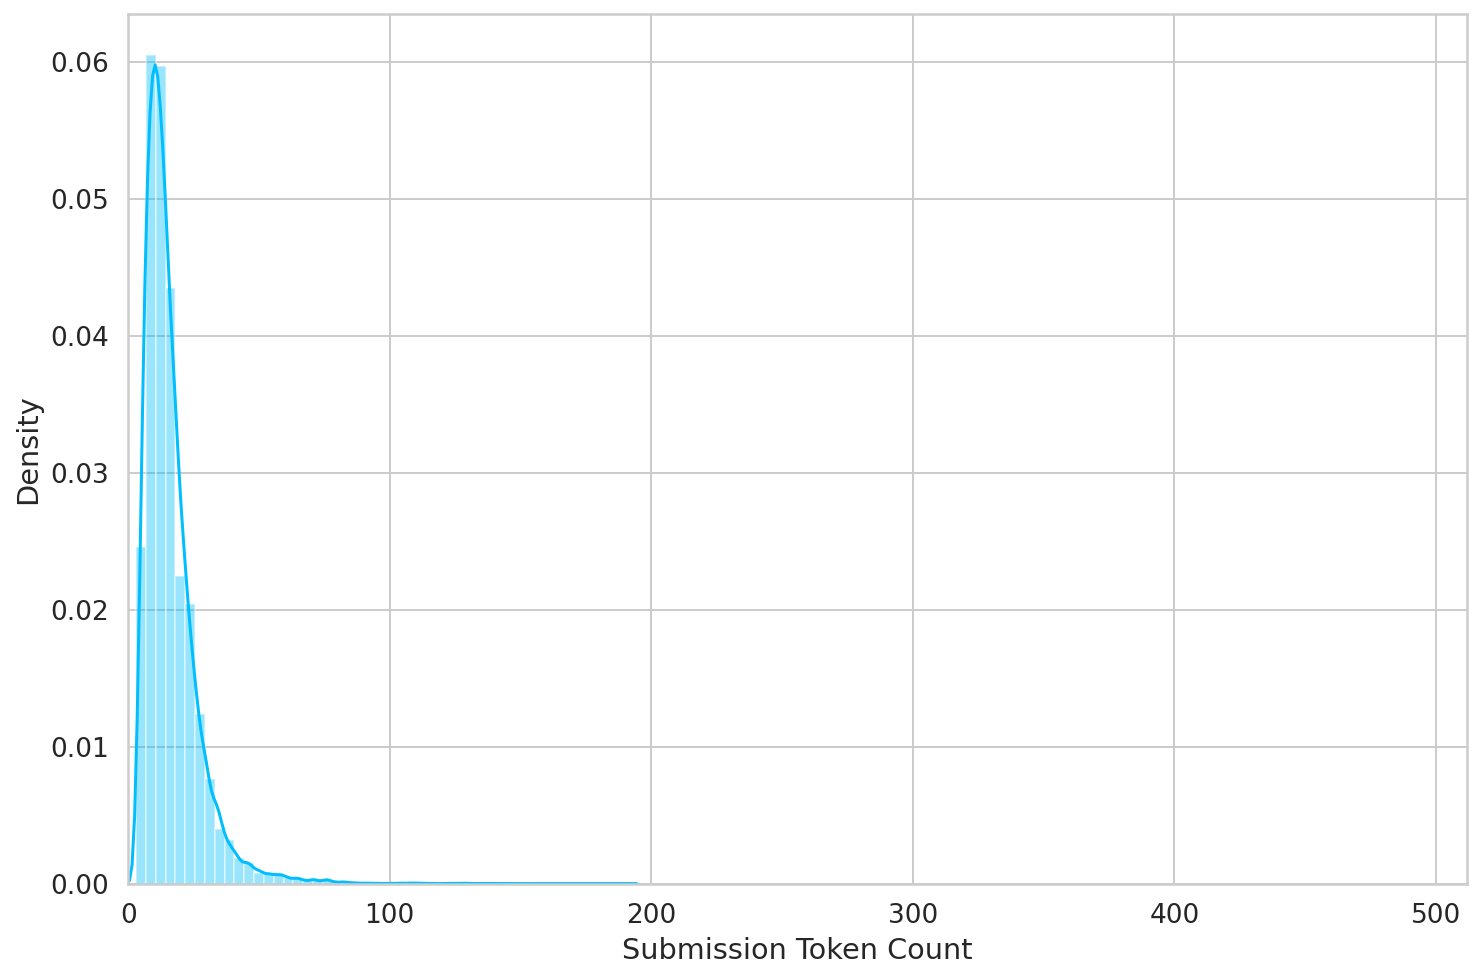

In [ ]:
submission_token_lens.sort()
print(submission_token_lens)
sns.distplot(submission_token_lens)
plt.xlim([0, 512]);
plt.xlabel('Submission Token Count');

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


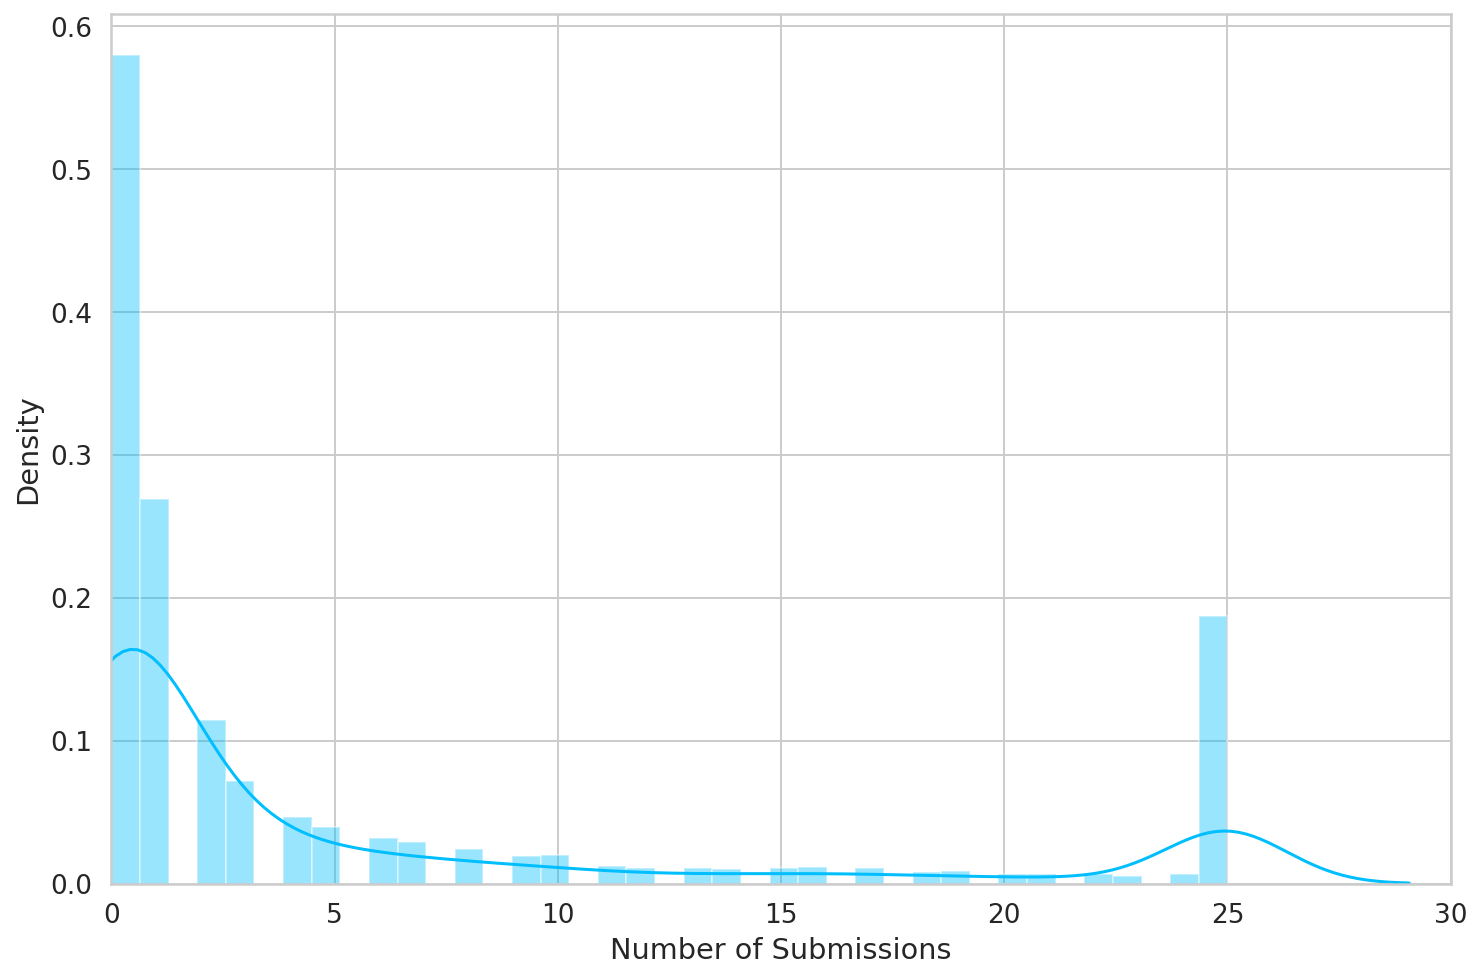

In [ ]:
num_submissions.sort()
print(num_submissions)
print(max(num_submissions))
sns.distplot(num_submissions)
plt.xlim([0, 30]);
plt.xlabel('Number of Submissions');

In [ ]:
MAX_TEXT_LEN = 160
MAX_ITEMS = 5

In [ ]:
class botData(Dataset):

  def __init__(self, comments, submissions, numerical_data, targets, tokenizer, max_text_len, max_items):
    self.comments = comments
    self.submissions = submissions
    self.x = numerical_data
    self.num_entries = len(self.x)

    self.targets = targets
    self.tokenizer = tokenizer
    self.max_text_len = max_text_len
    self.max_items = max_items
  
  def __len__(self):
    return self.num_entries

  def get_encoding(self, phrases):
    final_input_ids = None
    final_attention_mask = None
    num_items = len(phrases)
    for i in range(self.max_items):
      if i >= len(phrases):
        input_ids = torch.zeros((1,self.max_text_len), dtype=torch.long)
        attention_mask = torch.zeros((1,self.max_text_len), dtype=torch.long)
      else:
        phrase = phrases[i]
        encoding = self.tokenizer.encode_plus(
          str(phrase),
          add_special_tokens=True,
          max_length=self.max_text_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
      
      if final_input_ids == None:
        final_input_ids = input_ids
        final_attention_mask = attention_mask
      else:
        final_input_ids = torch.cat((final_input_ids, input_ids))
        final_attention_mask = torch.cat((final_attention_mask, attention_mask))
    
    return final_input_ids, final_attention_mask, num_items
  
  def __getitem__(self, idx):
    comments = self.comments[idx]
    submissions = self.submissions[idx]
    x = self.x[idx]
    target = self.targets[idx]

    comments_input_ids, comments_attention_mask, num_comments = self.get_encoding(comments)
    submissions_input_ids, submissions_attention_mask, num_submissions = self.get_encoding(submissions)

    return {
      # 'comments': comments,
      # 'submissions': submissions,
      'num_comments' : num_comments,
      'num_submissions' : num_submissions,
      'comments_input_ids': comments_input_ids,
      'comments_attention_mask': comments_attention_mask,
      'submissions_input_ids': submissions_input_ids,
      'submissions_attention_mask': submissions_attention_mask,
      'x': torch.tensor(x, dtype=torch.float),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((9012, 9), (501, 9), (501, 9))

In [ ]:
def create_data_loader(df, tokenizer, max_text_len, max_items, batch_size):
  ds = botData(
    comments=df.comments.to_numpy(),
    submissions=df.submissions.to_numpy(),
    numerical_data=np.concatenate((np.concatenate((df.iloc[:,0:1].values, df.iloc[:,2:3].values), axis = 1), df.iloc[:,4:8].values), axis = 1),
    targets=df.is_bot.to_numpy(),
    tokenizer=tokenizer,
    max_text_len=max_text_len,
    max_items=max_items
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
  )

In [ ]:
print(np.concatenate((df.iloc[:,0:1].values, df.iloc[:,2:8].values), axis = 1))
print(df.is_bot.to_numpy())
print(df.iloc[:,0:1])
print(df.comments.to_numpy())

[[  -7    1    1 ...    0    0    1]
 [  -5    0    1 ...    0    0    1]
 [  -4    0    1 ...    0    0    1]
 ...
 [   2    0    0 ...    0    0    1]
 [2363    1    0 ...    0    1   91]
 [   0    0    0 ...    0    0    1]]
[1 1 1 ... 0 0 0]
       comment_karma
0                 -7
1                 -5
2                 -4
3                  0
4                 -2
...              ...
10009              6
10010              0
10011              2
10012           2363
10013              0

[10014 rows x 1 columns]
[list(['By submitting to an independent, non-profit community, the authors volunteered on a Good Samaritan basis to spread wokeness', "Sorry, but if you bothered to read the article below the video you could've gotten the point", 'That is not a personal blog'])
 list(['Only 125? Why not 10?\nIslamic state has captured half Syria, they are close to Baghdad and keep advancing while all western leaders do is simply taking some minor measures. Smh', 'What? Any other wild gues

In [ ]:
import collections

def collate_fn(batch):
    super_dict = collections.defaultdict(list)
    for d in batch:
        for k, v in d.items():  # d.items() in Python 3+
            super_dict[k].append(v)
    # print(super_dict)
    return super_dict

In [ ]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_TEXT_LEN, MAX_ITEMS, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_TEXT_LEN, MAX_ITEMS, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_TEXT_LEN, MAX_ITEMS, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['num_comments', 'num_submissions', 'comments_input_ids', 'comments_attention_mask', 'submissions_input_ids', 'submissions_attention_mask', 'x', 'targets'])

In [ ]:
print(len(data['comments_input_ids']))
print(data['num_comments'])
print(data['comments_input_ids'][0][0].shape)
# print(data['comments_attention_mask'].shape)
# print(data['targets'].shape)

4
tensor([25,  1, 18,  2])
torch.Size([160])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(encoding['input_ids'].shape)
print(encoding['attention_mask'].shape)

pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

torch.Size([1, 32])
torch.Size([1, 32])


In [ ]:
bert_model.config.hidden_size

768

In [ ]:
pooled_output.last_hidden_state
pooled_output.last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self):
    super(SentimentClassifier, self).__init__()
    self.bert_comments = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.bert_submissions = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(6, self.bert_comments.config.hidden_size)
    self.out = nn.Linear(self.bert_comments.config.hidden_size * 2, 2)
  
  def forward(self, comments_input_ids, comments_attention_mask, num_comments, submissions_input_ids, submissions_attention_mask, num_submissions, x):
    batch_size = len(comments_input_ids)
    res = torch.zeros(batch_size, self.bert_comments.config.hidden_size).to(device)
    for i in range(batch_size):
      if num_comments[i] > 0:
        pooled_output = self.bert_comments(
          input_ids=comments_input_ids[i,:num_comments[i],:],
          attention_mask=comments_attention_mask[i,:num_comments[i],:]
        )
        res[i,:] = torch.sum(pooled_output.pooler_output, dim=0)

    comments_output = self.drop(res)
    x_output = nn.functional.relu(self.linear(x))
    output = torch.cat((comments_output, x_output), 1)
    return self.out(output)

In [ ]:
model = SentimentClassifier()
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transf

In [ ]:
comments_input_ids = data['comments_input_ids'].to(device)
comments_attention_mask = data['comments_attention_mask'].to(device)
num_comments = data['num_comments'].to(device)
submissions_input_ids = data['submissions_input_ids'].to(device)
submissions_attention_mask = data['submissions_attention_mask'].to(device)
num_submissions = data['num_submissions'].to(device)
x = data['x'].to(device)

# print(input_ids.shape) # batch size x seq length
# print(attention_mask.shape) # batch size x seq length

In [ ]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)

print(input.shape)
print(output.shape)

torch.Size([2, 3])
torch.Size([2, 3])


In [ ]:
print(F.softmax(model(comments_input_ids, comments_attention_mask, num_comments, submissions_input_ids, submissions_attention_mask, num_submissions, x), dim=1).shape)
# print(model(x, input_ids, attention_mask))
# print(torch.nn.functional.softmax(model(x, input_ids, attention_mask), dim=1).shape)

torch.Size([4, 2])


In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

print(input.shape)
print(target.shape)

torch.Size([3, 5])
torch.Size([3])


In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for i, d in enumerate(data_loader):
    comments_input_ids = d['comments_input_ids'].to(device)
    comments_attention_mask = d['comments_attention_mask'].to(device)
    num_comments = d['num_comments'].to(device)
    submissions_input_ids = d['submissions_input_ids'].to(device)
    submissions_attention_mask = d['submissions_attention_mask'].to(device)
    num_submissions = d['num_submissions'].to(device)
    x = d['x'].to(device)
    targets = d["targets"].to(device)

    outputs = model(comments_input_ids, comments_attention_mask, num_comments, submissions_input_ids, submissions_attention_mask, num_submissions, x)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      comments_input_ids = d['comments_input_ids'].to(device)
      comments_attention_mask = d['comments_attention_mask'].to(device)
      num_comments = d['num_comments'].to(device)
      submissions_input_ids = d['submissions_input_ids'].to(device)
      submissions_attention_mask = d['submissions_attention_mask'].to(device)
      num_submissions = d['num_submissions'].to(device)
      x = d['x'].to(device)
      targets = d["targets"].to(device)

      outputs = model(comments_input_ids, comments_attention_mask, num_comments, submissions_input_ids, submissions_attention_mask, num_submissions, x)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    # torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Train loss 6.053373452269169 accuracy 0.9328672880603639


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 34.30886643159804 accuracy 0.966067864271457

Epoch 2/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 7.137009488410061 accuracy 0.9571682201509099


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 39.427492856704205 accuracy 0.966067864271457

Epoch 3/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 7.240221735530969 accuracy 0.9570572569906791


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 41.87655543038454 accuracy 0.9700598802395208

Epoch 4/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [ ]:
torch.save(model.state_dict(), f'{dir}/model_2.pth')

# # download checkpoint file
# files.download('checkpoint.pth')

In [ ]:
state_dict = torch.load(f'{dir}/model_2.pth')
model.load_state_dict(state_dict)

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      x = d["x"].to(device)

      outputs = model(
        x=x,
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values

In [ ]:
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)